# COMSE6998 009 Final Project

**Sources:** 
- https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
- https://www.tensorflow.org/recommenders/examples/dcn 
- https://keras.io/examples/structured_data/wide_deep_cross_networks/ 

In [34]:
import math
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split

In [2]:
ratings = tfds.load("movielens/100k-ratings", split="train")

In [3]:
ratings_df = tfds.as_dataframe(ratings)

In [4]:
proc_df = ratings_df.copy()

feature_names = ["movie_id", "movie_title", "user_id", "user_gender", "user_zip_code", "user_occupation_text", "bucketized_user_age"]
str_features = ["movie_id", "user_id", "user_zip_code", "user_occupation_text"]
num_features = ["user_gender", "bucketized_user_age"]
target_feature = "user_rating"

proc_df["movie_title"] = proc_df["movie_title"].str.decode("utf-8")

for feature in num_features:
  proc_df[feature] = proc_df[feature].astype("float32")

for feature in str_features:
  proc_df[feature] = proc_df[feature].str.decode("utf-8")

proc_df[target_feature] = proc_df[target_feature].astype('float32')

proc_df.head(10)

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],357,One Flew Over the Cuckoo's Nest (1975),46.0,879024327,1.0,138,4,doctor,4.0,53211
1,25.0,"[4, 14]",709,Strictly Ballroom (1992),32.0,875654590,1.0,92,5,entertainment,2.0,80525
2,18.0,[4],412,"Very Brady Sequel, A (1996)",24.0,882075110,1.0,301,17,student,4.0,55439
3,50.0,"[5, 7]",56,Pulp Fiction (1994),50.0,883326919,1.0,60,4,healthcare,4.0,06472
4,50.0,"[10, 16]",895,Scream 2 (1997),55.0,891409199,1.0,197,18,technician,3.0,75094
5,18.0,"[7, 16]",325,Crash (1996),19.0,876346551,0.0,601,1,artist,4.0,99687
6,18.0,"[2, 3, 4, 12]",95,Aladdin (1992),19.0,882064434,1.0,710,17,student,3.0,92020
7,25.0,"[0, 5, 14]",92,True Romance (1993),34.0,875135363,1.0,833,21,writer,2.0,90019
8,25.0,[4],425,Bob Roberts (1992),27.0,880844102,1.0,916,18,engineer,5.0,N2L5N
9,25.0,"[0, 1, 15, 18]",271,Starship Troopers (1997),32.0,884801053,1.0,940,2,administrator,2.0,02215


In [5]:
titles = proc_df.set_index("movie_id")["movie_title"].to_dict()

In [6]:
titles["95"]

'Aladdin (1992)'

In [7]:
str_features_vocab = {
    "movie_id": list(proc_df["movie_id"].unique()),
    "user_id": list(proc_df["user_id"].unique()),
    "user_zip_code": list(proc_df["user_zip_code"].unique()),
    "user_occupation_text": list(proc_df["user_occupation_text"].unique()),
}

csv_header = str_features + num_features + [target_feature]

model_features = num_features + str_features

col_defaults = [
    [0.0] if feature_name in num_features + [target_feature] else ["NA"]
    for feature_name in csv_header
]

NUM_CLASSES = len(proc_df["user_rating"].unique())

In [8]:
proc_df = proc_df[str_features + num_features + [target_feature]]

train, test = train_test_split(proc_df, test_size=0.2, random_state=6998)

In [9]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train.to_csv(train_data_file, index=False)
test.to_csv(test_data_file, index=False)

In [10]:
!head train_data.csv

movie_id,user_id,user_zip_code,user_occupation_text,user_gender,bucketized_user_age,user_rating
129,758,53706,student,1.0,25.0,4.0
69,122,22206,writer,0.0,25.0,2.0
168,187,16801,educator,1.0,25.0,5.0
732,488,21012,technician,1.0,45.0,4.0
28,622,14850,programmer,1.0,25.0,3.0
1091,416,92626,student,0.0,18.0,3.0
796,314,08043,student,0.0,18.0,2.0
234,880,83702,student,1.0,1.0,5.0
174,660,77380,student,1.0,25.0,4.0


In [11]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=csv_header,
        column_defaults=col_defaults,
        label_name="user_rating",
        num_epochs=1,
        header=True,
        shuffle=shuffle
    )
    return dataset.cache()

train_data = get_dataset_from_csv(train_data_file, 1024)
test_data = get_dataset_from_csv(test_data_file, 1024)

In [12]:
train_data

<CacheDataset element_spec=(OrderedDict([('movie_id', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('user_id', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('user_zip_code', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('user_occupation_text', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('user_gender', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('bucketized_user_age', TensorSpec(shape=(None,), dtype=tf.float32, name=None))]), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [13]:
for x in train_data.take(3):
  print(x)

(OrderedDict([('movie_id', <tf.Tensor: shape=(1024,), dtype=string, numpy=array([b'129', b'69', b'168', ..., b'100', b'69', b'17'], dtype=object)>), ('user_id', <tf.Tensor: shape=(1024,), dtype=string, numpy=array([b'758', b'122', b'187', ..., b'790', b'719', b'757'], dtype=object)>), ('user_zip_code', <tf.Tensor: shape=(1024,), dtype=string, numpy=
array([b'53706', b'22206', b'16801', ..., b'80913', b'V0R2H', b'55104'],
      dtype=object)>), ('user_occupation_text', <tf.Tensor: shape=(1024,), dtype=string, numpy=
array([b'student', b'writer', b'educator', ..., b'technician', b'other',
       b'student'], dtype=object)>), ('user_gender', <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([1., 0., 1., ..., 1., 0., 1.], dtype=float32)>), ('bucketized_user_age', <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([25., 25., 25., ..., 25., 35., 25.], dtype=float32)>)]), <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([4., 2., 5., ..., 2., 5., 3.], dtype=float32)>)
(OrderedDict(

In [14]:
def create_model_inputs():
    inputs = {}
    for feature_name in model_features:
        if feature_name in num_features:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [15]:
from tensorflow.keras.layers import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in str_features:
            vocabulary = str_features_vocab[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [16]:
learning_rate = 0.001
dropout_rate = 0.1

def create_wide_and_deep_model(hidden_units):

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=1, activation="relu")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
wide_and_deep_model = create_wide_and_deep_model([32, 32])

wide_and_deep_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()],
)

print("Start training the model...")
history = wide_and_deep_model.fit(train_data, epochs=10)
print("Model training finished")

_, accuracy = wide_and_deep_model.evaluate(test_data, verbose=0)

print(f"Test rmse: {round(accuracy, 4)}%")

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Start training the model...
Epoch 1/10
79/79 [==============================] - 5s 36ms/step - loss: 3.2470 - root_mean_squared_error: 1.8019
Epoch 2/10
79/79 [==============================] - 2s 26ms/step - loss: 1.0056 - root_mean_squared_error: 1.0028
Epoch 3/10
79/79 [==============================] - 2s 26ms/step - loss: 0.9153 - root_mean_squared_error: 0.9567
Epoch 4/10
79/79 [==============================] - 2s 27ms/step - loss: 0.8830 - root_mean_squared_error: 0.9397
Epoch 5/10
79/79 [==============================] - 2s 26ms/step - loss: 0.8646 - root_mean_squared_error: 0.9298
Epoch 6/10
79/79 [==============================] - 2s 26ms/step - loss: 0.8497 - root_mean_squared_error: 0.9218
Epoch 7/10
79/79 [==============================] - 2s 26ms/step - loss: 0.8382 - root_mean_squared_error: 0.9156
Epoch 8/10
79/79 [==============================] - 2s 26ms/step - loss: 0.8260 - root_mean_squared_error: 0.9088
Epoch 9/10
79/79 [==============================] - 2s 26ms/

In [18]:
def create_deep_and_cross_model(hidden_units):

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=1, activation="relu")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
deep_and_cross_model = create_deep_and_cross_model([32, 32])

deep_and_cross_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.RootMeanSquaredError()],
)

print("Start training the model...")
history = deep_and_cross_model.fit(train_data, epochs=10)
print("Model training finished")

_, accuracy = deep_and_cross_model.evaluate(test_data, verbose=0)

print(f"Test rmse: {round(accuracy, 4)}")

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Start training the model...
Epoch 1/10
79/79 [==============================] - 5s 20ms/step - loss: 4.6780 - root_mean_squared_error: 2.1629
Epoch 2/10
79/79 [==============================] - 2s 19ms/step - loss: 3.1805 - root_mean_squared_error: 1.7834
Epoch 3/10
79/79 [==============================] - 2s 20ms/step - loss: 3.0340 - root_mean_squared_error: 1.7418
Epoch 4/10
79/79 [==============================] - 2s 19ms/step - loss: 2.9925 - root_mean_squared_error: 1.7299
Epoch 5/10
79/79 [==============================] - 2s 20ms/step - loss: 2.9416 - root_mean_squared_error: 1.7151
Epoch 6/10
79/79 [==============================] - 2s 19ms/step - loss: 2.8951 - root_mean_squared_error: 1.7015
Epoch 7/10
79/79 [==============================] - 2s 19ms/step - loss: 2.8139 - root_mean_squared_error: 1.6775
Epoch 8/10
79/79 [==============================] - 2s 19ms/step - loss: 2.7180 - root_mean_squared_error: 1.6486
Epoch 9/10
79/79 [==============================] - 2s 19ms/

### Demo

In [ ]:
demo = test_data.take(1)

In [ ]:
test = demo.as_numpy_iterator()
test = next(test)
decoder = np.vectorize(lambda x: x.decode("utf-8"))

# Get Demo Movie Info
movies = decoder(test[0]["movie_id"][:5])
movie_titles = [titles[movie] for movie in movies]

# Get Demo User Info
users = decoder(test[0]["user_id"][:5])
user_ages = test[0]["bucketized_user_age"][:5]
user_genders = test[0]["user_gender"][:5]
user_jobs = decoder(test[0]["user_occupation_text"][:5])

# Get Predictions
wd_preds = wide_and_deep_model.predict(demo)[:5].reshape(-1)
dcn_preds = deep_and_cross_model.predict(demo)[:5].reshape(-1)
truth = test[1][:5]

# Create df
demo_data = {"user": users,
     "age": user_ages,
     "gender": user_genders,
     "job": user_jobs,
     "movie": movie_titles,
     "wd pred": wd_preds,
     "dcn pred": dcn_preds,
     "actual rating": truth
    }

demo_df = pd.DataFrame(demo_data)

In [ ]:
demo_df

,user,age,gender,job,movie,wd pred,dcn pred,actual rating
0,693,35.0,0.0,healthcare,M*A*S*H (1970),3.581419,3.973485,2.0
1,805,25.0,0.0,other,"Bridges of Madison County, The (1995)",3.161812,3.203399,1.0
2,883,45.0,1.0,librarian,Schindler's List (1993),4.905088,0.000000,4.0
3,343,35.0,1.0,engineer,"Boot, Das (1981)",4.561292,4.543575,4.0
4,854,25.0,0.0,student,Die Hard (1988),3.496659,3.656999,3.0


### Experiments

In [25]:
EPOCHS = [25, 50, 75, 100]

epoch_rmses_w = []
epoch_times_w = []
epoch_rmses_c = []
epoch_times_c = []

for epoch_val in EPOCHS:

  # Wide and Deep Train
  wide_and_deep_model = create_wide_and_deep_model([32, 32])
  wide_and_deep_model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
          loss=keras.losses.MeanSquaredError(),
          metrics=[keras.metrics.RootMeanSquaredError()],
  )

  start = time.time()
  history = wide_and_deep_model.fit(train_data, epochs=epoch_val)
  elapsed_time = time.time() - start

  _, rmse = wide_and_deep_model.evaluate(test_data, verbose=0)

  epoch_rmses_w.append(rmse)
  epoch_times_w.append(elapsed_time)

  # Deep Cross Train
  deep_and_cross_model = create_deep_and_cross_model([32, 32])
  deep_and_cross_model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
          loss=keras.losses.MeanSquaredError(),
          metrics=[keras.metrics.RootMeanSquaredError()],
  )

  start = time.time()
  history = deep_and_cross_model.fit(train_data, epochs=epoch_val)
  elapsed_time = time.time() - start

  _, rmse = deep_and_cross_model.evaluate(test_data, verbose=0)

  epoch_rmses_c.append(rmse)
  epoch_times_c.append(elapsed_time)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Epoch 1/25
79/79 [==============================] - 4s 26ms/step - loss: 3.4057 - root_mean_squared_error: 1.8455
Epoch 2/25
79/79 [==============================] - 2s 26ms/step - loss: 1.0085 - root_mean_squared_error: 1.0042
Epoch 3/25
79/79 [==============================] - 2s 26ms/step - loss: 0.9091 - root_mean_squared_error: 0.9535
Epoch 4/25
79/79 [==============================] - 2s 26ms/step - loss: 0.8823 - root_mean_squared_error: 0.9393
Epoch 5/25
79/79 [==============================] - 2s 26ms/step - loss: 0.8635 - root_mean_squared_error: 0.9293
Epoch 6/25
79/79 [==============================] - 2s 26ms/step - loss: 0.8514 - root_mean_squared_error: 0.9227
Epoch 7/25
79/79 [==============================] - 2s 28ms/step - loss: 0.8370 - root_mean_squared_error: 0.9149
Epoch 8/25
79/79 [==============================] - 2s 26ms/step - loss: 0.8254 - root_mean_squared_error: 0.9085
Epoch 9/25
79/79 [==============================] - 2s 26ms/step - loss: 0.8142 - root_m

In [26]:
HIDDEN_UNITS_TOTAL = [[32, 32], [64, 64], [128, 128], [256, 256]]

total_rmses_w = []
total_times_w = []
total_rmses_c = []
total_times_c = []

for total_units in HIDDEN_UNITS_TOTAL:

  # Wide and Deep Train
  wide_and_deep_model = create_wide_and_deep_model(total_units)
  wide_and_deep_model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
          loss=keras.losses.MeanSquaredError(),
          metrics=[keras.metrics.RootMeanSquaredError()],
  )

  start = time.time()
  history = wide_and_deep_model.fit(train_data, epochs=20)
  elapsed_time = time.time() - start

  _, rmse = wide_and_deep_model.evaluate(test_data, verbose=0)

  total_rmses_w.append(rmse)
  total_times_w.append(elapsed_time)

  # Deep Cross Train
  deep_and_cross_model = create_deep_and_cross_model(total_units)
  deep_and_cross_model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
          loss=keras.losses.MeanSquaredError(),
          metrics=[keras.metrics.RootMeanSquaredError()],
  )

  start = time.time()
  history = deep_and_cross_model.fit(train_data, epochs=20)
  elapsed_time = time.time() - start

  _, rmse = deep_and_cross_model.evaluate(test_data, verbose=0)

  total_rmses_c.append(rmse)
  total_times_c.append(elapsed_time)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Epoch 1/20
79/79 [==============================] - 4s 26ms/step - loss: 3.3588 - root_mean_squared_error: 1.8327
Epoch 2/20
79/79 [==============================] - 2s 25ms/step - loss: 1.0190 - root_mean_squared_error: 1.0094
Epoch 3/20
79/79 [==============================] - 2s 26ms/step - loss: 0.9140 - root_mean_squared_error: 0.9560
Epoch 4/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8823 - root_mean_squared_error: 0.9393
Epoch 5/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8648 - root_mean_squared_error: 0.9299
Epoch 6/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8477 - root_mean_squared_error: 0.9207
Epoch 7/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8347 - root_mean_squared_error: 0.9136
Epoch 8/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8194 - root_mean_squared_error: 0.9052
Epoch 9/20
79/79 [==============================] - 2s 26ms/step - loss: 0.8074 - root_m

In [27]:
HIDDEN_UNITS_DEPTH = [[256], [128, 128], [64, 128, 64], [64, 64, 64, 64]]


depth_rmses_w = []
depth_times_w = []
depth_rmses_c = []
depth_times_c = []

for depth in HIDDEN_UNITS_DEPTH:

  # Wide and Deep Train
  wide_and_deep_model = create_wide_and_deep_model(depth)
  wide_and_deep_model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
          loss=keras.losses.MeanSquaredError(),
          metrics=[keras.metrics.RootMeanSquaredError()],
  )

  start = time.time()
  history = wide_and_deep_model.fit(train_data, epochs=20)
  elapsed_time = time.time() - start

  _, rmse = wide_and_deep_model.evaluate(test_data, verbose=0)

  depth_rmses_w.append(rmse)
  depth_times_w.append(elapsed_time)

  # Deep Cross Train
  deep_and_cross_model = create_deep_and_cross_model(depth)
  deep_and_cross_model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
          loss=keras.losses.MeanSquaredError(),
          metrics=[keras.metrics.RootMeanSquaredError()],
  )

  start = time.time()
  history = deep_and_cross_model.fit(train_data, epochs=20)
  elapsed_time = time.time() - start

  _, rmse = deep_and_cross_model.evaluate(test_data, verbose=0)

  depth_rmses_c.append(rmse)
  depth_times_c.append(elapsed_time)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Epoch 1/20
79/79 [==============================] - 4s 25ms/step - loss: 2.8401 - root_mean_squared_error: 1.6852
Epoch 2/20
79/79 [==============================] - 2s 25ms/step - loss: 0.9452 - root_mean_squared_error: 0.9722
Epoch 3/20
79/79 [==============================] - 2s 26ms/step - loss: 0.9058 - root_mean_squared_error: 0.9517
Epoch 4/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8861 - root_mean_squared_error: 0.9413
Epoch 5/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8760 - root_mean_squared_error: 0.9359
Epoch 6/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8657 - root_mean_squared_error: 0.9304
Epoch 7/20
79/79 [==============================] - 2s 26ms/step - loss: 0.8535 - root_mean_squared_error: 0.9238
Epoch 8/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8431 - root_mean_squared_error: 0.9182
Epoch 9/20
79/79 [==============================] - 2s 25ms/step - loss: 0.8319 - root_m

In [28]:
np.save("epoch_rmses_w.npy", np.asarray(epoch_rmses_w))
np.save("epoch_times_w.npy", np.asarray(epoch_times_w))
np.save("epoch_rmses_c.npy", np.asarray(epoch_rmses_c))
np.save("epoch_times_c.npy", np.asarray(epoch_times_c))

np.save("total_rmses_w.npy", np.asarray(total_rmses_w))
np.save("total_times_w.npy", np.asarray(total_times_w))
np.save("total_rmses_c.npy", np.asarray(total_rmses_c))
np.save("total_times_c.npy", np.asarray(total_times_c))

np.save("depth_rmses_w.npy", np.asarray(depth_rmses_w))
np.save("depth_times_w.npy", np.asarray(depth_times_w))
np.save("depth_rmses_c.npy", np.asarray(depth_rmses_c))
np.save("depth_times_c.npy", np.asarray(depth_times_c))

In [58]:
print(epoch_rmses_w)
print(epoch_times_w)
print(epoch_rmses_c)
print(epoch_times_c)

[0.9882488250732422, 1.0180264711380005, 1.0612058639526367, 1.0326437950134277]
[62.68381452560425, 121.58005619049072, 176.14721584320068, 240.75050115585327]
[1.2171990871429443, 1.2897398471832275, 1.3476860523223877, 1.3550769090652466]
[50.9395854473114, 106.37606048583984, 166.43381595611572, 206.55670356750488]


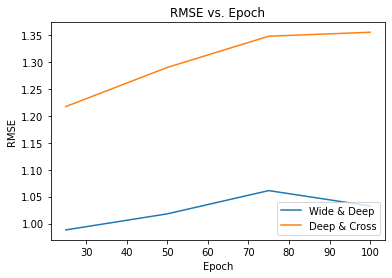

In [59]:
plt.plot(EPOCHS, epoch_rmses_w, label="Wide & Deep")
plt.plot(EPOCHS, epoch_rmses_c, label="Deep & Cross")
plt.title("RMSE vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(loc=4)
plt.show()

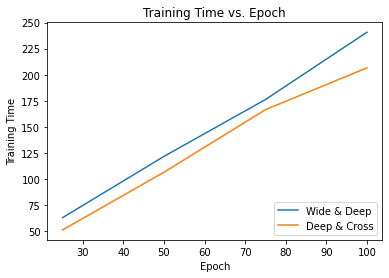

In [68]:
plt.plot(EPOCHS, epoch_times_w, label="Wide & Deep")
plt.plot(EPOCHS, epoch_times_c, label="Deep & Cross")
plt.title("Training Time vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Time")
plt.legend(loc=4)
plt.show()

In [61]:
print(total_rmses_w)
print(total_times_w)
print(total_rmses_c)
print(total_times_c)

[0.9963741898536682, 0.9913473725318909, 0.9917793869972229, 1.238751769065857]
[49.18686580657959, 48.021941900253296, 49.85606908798218, 48.90859508514404]
[1.399292230606079, 1.1135985851287842, 1.1194506883621216, 1.0820802450180054]
[44.01535129547119, 40.500351905822754, 41.321784019470215, 43.24942469596863]


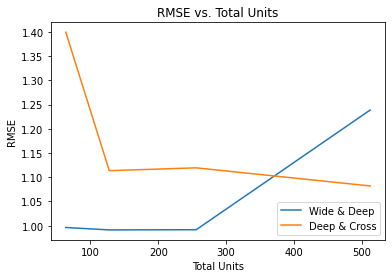

In [62]:
plt.plot([64, 128, 256, 512], total_rmses_w, label="Wide & Deep")
plt.plot([64, 128, 256, 512], total_rmses_c, label="Deep & Cross")
plt.title("RMSE vs. Total Units")
plt.xlabel("Total Units")
plt.ylabel("RMSE")
plt.legend(loc=4)
plt.show()

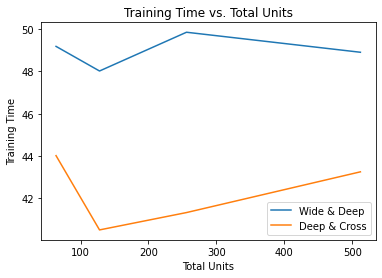

In [67]:
plt.plot([64, 128, 256, 512], total_times_w, label="Wide & Deep")
plt.plot([64, 128, 256, 512], total_times_c, label="Deep & Cross")
plt.title("Training Time vs. Total Units")
plt.xlabel("Total Units")
plt.ylabel("Training Time")
plt.legend(loc=4)
plt.show()

In [64]:
print(depth_rmses_w)
print(depth_times_w)
print(depth_rmses_c)
print(depth_times_c)

[0.9635750651359558, 0.9924604296684265, 1.0111415386199951, 1.0005640983581543]
[47.439167737960815, 49.261711835861206, 52.32163071632385, 51.539340019226074]
[1.076924204826355, 1.1029125452041626, 1.1312181949615479, 1.079906702041626]
[42.21606945991516, 42.193166971206665, 48.009745359420776, 46.22439622879028]


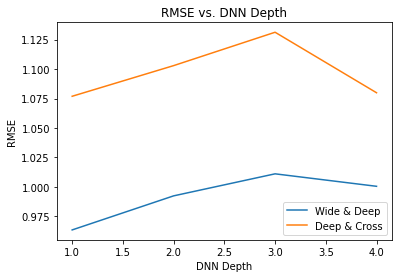

In [65]:
plt.plot(range(1,5), depth_rmses_w, label="Wide & Deep")
plt.plot(range(1,5), depth_rmses_c, label="Deep & Cross")
plt.title("RMSE vs. DNN Depth")
plt.xlabel("DNN Depth")
plt.ylabel("RMSE")
plt.legend(loc=4)
plt.show()

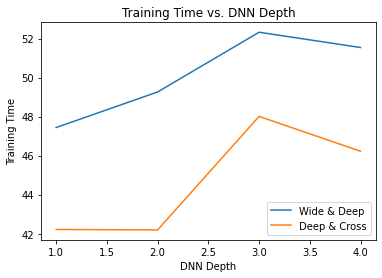

In [66]:
plt.plot(range(1,5), depth_times_w, label="Wide & Deep")
plt.plot(range(1,5), depth_times_c, label="Deep & Cross")
plt.title("Training Time vs. DNN Depth")
plt.xlabel("DNN Depth")
plt.ylabel("Training Time")
plt.legend(loc=4)
plt.show()